### Setup

Install required packages, download the datasets and pretrained model

In [17]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
All required packages have been successfully installed!


In [18]:
import copy
import math
import random
import time
import numpy as np
import torch

from collections import OrderedDict, defaultdict
from typing import Union, List
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

import torch.nn.functional as F

assert torch.cuda.is_available(), \
    'Current runtime does not have CUDA support.' \
    'Please select in menu bar Runtime - Change runtime type -> GPU'

In [19]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [42]:
def train(model: nn.Module,
          dataloader: DataLoader,
          criterion: nn.Module,
          optimizer: Optimizer,
          scheduler: StepLR,
          callbacks = None
          ) -> None:
    model.train()

    for inputs, targets in tqdm(dataloader, desc='Training', leave=False):
        # Move the data from CPU to GPU
        inputs = inputs.cuda()
        targets = targets.cuda()

        # Reset the gradients (from the last iteration)
        optimizer.zero_grad()

        # Forward inference
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward propagation
        loss.backward()

        # Update optimizer
        optimizer.step()

        if callbacks:
            for callback in callbacks:
                callback()

    # Update LR scheduler
    scheduler.step()

In [21]:
@torch.inference_mode()
def evaluate(model: nn.Module,
             dataloader: DataLoader,
             verbose=True) -> float:
    model.eval()

    num_correct = 0
    num_samples = 0

    for inputs, targets in tqdm(dataloader,
                                desc='Evaluating',
                                leave=False,
                                disable=not verbose):
        # Move the data from CPU to GPU
        inputs = inputs.cuda()
        targets = targets.cuda()

        # Forward inference
        outputs = model(inputs)

        # Convert logits to class indices
        outputs = outputs.argmax(dim=1)

        # Update metrics
        num_samples += targets.size(0)
        num_correct += (outputs == targets).sum()

    return (num_correct / num_samples * 100).item()

In [22]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)

def get_sparsity(tensor: torch.Tensor) -> float:
    """
    Calculate the sparsity of a tensor.
    sparsity = #zeros / #total = 1 - #nonzeros / #total
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()

def get_model_sparsity(model: nn.Module) -> float:
    num_nonzeros, total = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        total += param.numel()
    return 1 - float(num_nonzeros) / total

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    num_params = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_params += param.count_nonzero()
        else:
            num_params += param.numel()
    return num_params

def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    return get_num_parameters(model, count_nonzero_only) * data_width

byte = 8
kib = 1024 * byte
mib = 1024 * kib
gib = 1024 * mib

In [23]:
def fine_grained_prune(tensor: torch.Tensor, sparsity: float) -> torch.Tensor:
    """
    Magnitude-based pruning of a tensor.
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()
    num_zeros = round(num_elements * sparsity)
    print('Number of zeros: ', num_zeros)

    importance = tensor.abs()
    print('Importance: ', importance)

    threshold = importance.view(-1).kthvalue(num_zeros).values
    print('Threshold: ', threshold)

    mask = torch.gt(importance, threshold)
    print('Mask: ', mask)

    tensor.mul_(mask)
    print('Mul_mask', tensor.mul_(mask))

    return mask


In [24]:
# Test
tensor = torch.tensor([[-1.0, 3.0, 5.0], [-2.0, -4.0, 6.0], [7.0, 8.0, -9.0]])
sparsity = 0.5 # prune 50% of the elements in the tensor
fine_grained_prune(tensor, sparsity)

Number of zeros:  4
Importance:  tensor([[1., 3., 5.],
        [2., 4., 6.],
        [7., 8., 9.]])
Threshold:  tensor(4.)
Mask:  tensor([[False, False,  True],
        [False, False,  True],
        [ True,  True,  True]])
Mul_mask tensor([[-0.,  0.,  5.],
        [-0., -0.,  6.],
        [ 7.,  8., -9.]])


tensor([[False, False,  True],
        [False, False,  True],
        [ True,  True,  True]])

In [25]:
tensor

tensor([[-0.,  0.,  5.],
        [-0., -0.,  6.],
        [ 7.,  8., -9.]])

In [37]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1:
                if isinstance(sparsity_dict, dict):
                    masks[name] = fine_grained_prune(param, sparsity_dict[name])
                else:
                    assert(sparsity_dict < 1 and sparsity_dict >= 0)
                    if sparsity_dict > 0:
                        masks[name] = fine_grained_prune(param, sparsity_dict)
        return masks

Load MNIST dataset

In [27]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

to_image = lambda t: (t * 0.3081 + 0.1307).squeeze(0).to('cpu').numpy()

dataset = {}
for split in ['train', 'test']:
    dataset[split] = MNIST('data',
                           train=(split=='train'),
                           download=(split=='train'),
                           transform=transforms)

dataloader = {}
for split in ['train', 'test']:
    dataloader[split] = DataLoader(dataset[split],
                                   batch_size=256 if split=='train' else 1000,
                                   shuffle=(split=='train'),
                                   num_workers=0,
                                   pin_memory=True)

In [28]:
demos = {0: 3, 1: 2, 2: 1, 3: 30, 4: 4, 5: 15, 6: 11, 7: 0, 8: 61, 9: 9}
demo_inputs, demo_images = [], []
for digit, index in demos.items():
    demo_inputs.append(copy.deepcopy(dataset['test'][index][0]))
    demo_images.append(to_image(demo_inputs[-1]))
demo_inputs = torch.stack(demo_inputs).cuda()
demo_inputs.shape

torch.Size([10, 1, 28, 28])

### Neural Network Model

In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) # 1x32x3x3 = 288 parameters
        self.conv2 = nn.Conv2d(32, 64, 3, 1) # 32x64x3x3 = 18,432 paramters
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128) # 9216x128 = 1,179,648 parameters
        self.fc2 = nn.Linear(128, 10) # 128x10 = 1,280 parameters

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Net().cuda()


### Demo Images Visualization

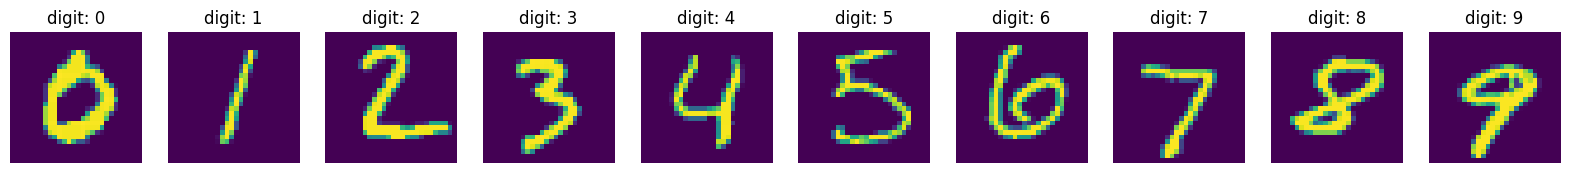

In [30]:
def visualize(with_predictions=False):
    plt.figure(figsize=(20, 10))
    predictions = model(demo_inputs).argmax(dim=1) if with_predictions else None
    for digit, index in demos.items():
        plt.subplot(1, 10, digit + 1)
        plt.imshow(demo_images[digit])
        if predictions is None:
            plt.title(f"digit: {digit}")
        else:
            plt.title(f"digit: {digit}\npred: {int(predictions[digit])}")
        plt.axis('off')
    plt.show()

visualize()

### Pretrain NN on MNIST

In [31]:
lr = 1.0
lr_step_gamma = 0.7
num_epochs = 5

optimizer = Adadelta(model.parameters(), lr=lr)
criterion = F.nll_loss
scheduler = StepLR(optimizer, step_size=1, gamma=lr_step_gamma)

best_accuracy = 0
best_checkpoint = dict()
for epoch in range(num_epochs):
    train(model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1:>2d} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

print(f"=> loading best checkpoint")
model.load_state_dict(best_checkpoint['state_dict'])

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  1 Accuracy 98.14% / Best Accuracy: 98.14%


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  2 Accuracy 98.66% / Best Accuracy: 98.66%


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  3 Accuracy 98.95% / Best Accuracy: 98.95%


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  4 Accuracy 98.96% / Best Accuracy: 98.96%


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch  5 Accuracy 98.94% / Best Accuracy: 98.96%
=> loading best checkpoint


<All keys matched successfully>

In [41]:
recover_model = lambda: model.load_state_dict(best_checkpoint['state_dict'])

### Evaluate Accuracy and Model Size of Dense Model

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Dense model has accuracy = 98.96%
Dense model has size = 4.58 MiB


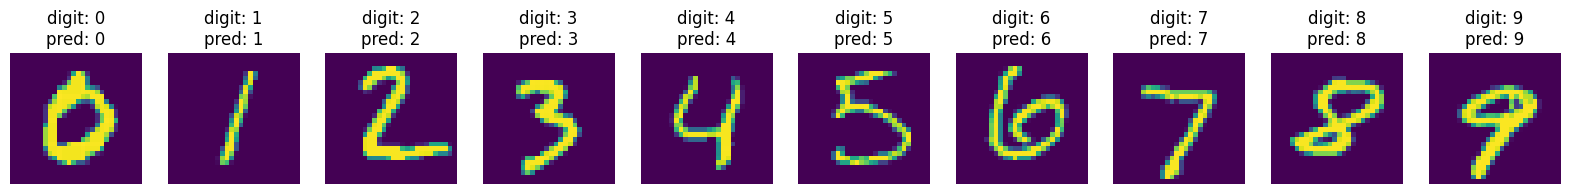

In [33]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"Dense model has accuracy = {dense_model_accuracy:.2f}%")
print(f"Dense model has size = {dense_model_size/mib:.2f} MiB")
visualize(True)

### Prune Model and Re-evaluate

Number of zeros:  259
Importance:  tensor([[[[0.1128, 0.0076, 0.3903],
          [0.2467, 0.1655, 0.1008],
          [0.1694, 0.3911, 0.0985]]],


        [[[0.0504, 0.1410, 0.1871],
          [0.4031, 0.2410, 0.1720],
          [0.1023, 0.2609, 0.3162]]],


        [[[0.3195, 0.1960, 0.1363],
          [0.2288, 0.0885, 0.2913],
          [0.0677, 0.0343, 0.3160]]],


        [[[0.3649, 0.2515, 0.0949],
          [0.1808, 0.2271, 0.2489],
          [0.1298, 0.2498, 0.3591]]],


        [[[0.1351, 0.3849, 0.3178],
          [0.1840, 0.0638, 0.0967],
          [0.0023, 0.4149, 0.3801]]],


        [[[0.2516, 0.1994, 0.2202],
          [0.2033, 0.0127, 0.2161],
          [0.3254, 0.0878, 0.0167]]],


        [[[0.2614, 0.2520, 0.0464],
          [0.1485, 0.2679, 0.2684],
          [0.3394, 0.2336, 0.2045]]],


        [[[0.1278, 0.2025, 0.0152],
          [0.0749, 0.0746, 0.1471],
          [0.3464, 0.3146, 0.2325]]],


        [[[0.1910, 0.3182, 0.3623],
          [0.3602, 0.0687, 0.3000

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

90.0% sparse model has accuracy = 18.05%
90.0% sparse model has size = 0.46 MiB, which is 9.98X smaller than the 4.58 MiB dense model


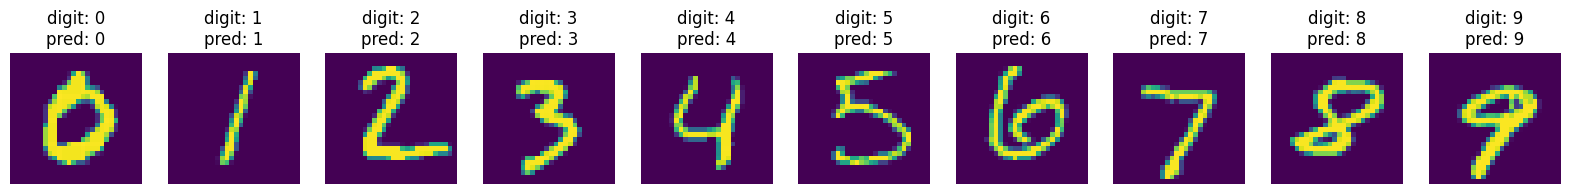

In [36]:
sparsity = 0.9
pruner = FineGrainedPruner(model, sparsity)
pruner.apply(model)
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
recover_model()

print(f"{sparsity*100}% sparse model has accuracy = {sparse_model_accuracy:.2f}%")
print(f"{sparsity*100}% sparse model has size = {sparse_model_size/mib:.2f} MiB, "
      f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
      f"the {dense_model_size/mib:.2f} MiB dense model")
visualize(True)

### Fine-tune the pruned model to get higher accuracy

In [38]:
evaluate(model, dataloader['test'])

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

98.95999908447266

In [39]:
num_finetune_epochs = 2
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)

best_sparse_checkpoint = dict()
best_sparse_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model,
          dataloader['train'],
          criterion,
          optimizer,
          scheduler,
          callbacks=[lambda: pruner.apply(model)])

    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_sparse_accuracy
    if is_best:
        best_sparse_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_sparse_accuracy = accuracy
    print(f'    Epoch {epoch+1} Sparse Accuracy {accuracy:.2f}% / Best Sparse Accuracy: {best_sparse_accuracy:.2f}%')


Finetuning Fine-grained Pruned Sparse Model


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 98.18% / Best Sparse Accuracy: 98.18%


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 98.49% / Best Sparse Accuracy: 98.49%


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

90.0% sparse model has accuracy = 98.49%
90.0% sparse model has size = 0.46 MiB, which is 9.98X smaller than the 4.58 MiB dense model


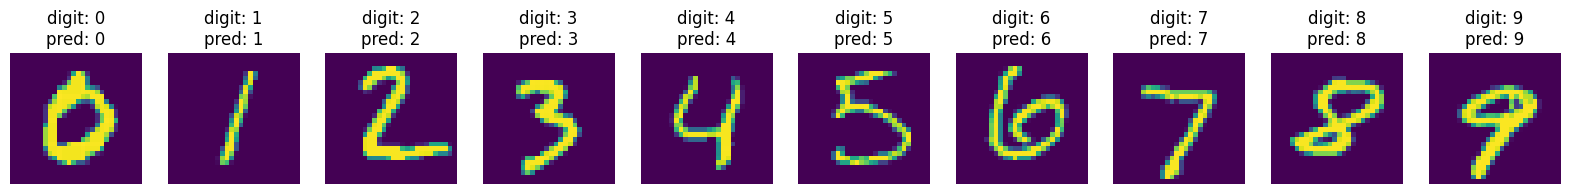

In [43]:
model.load_state_dict(best_sparse_checkpoint['state_dict'])
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"{sparsity*100}% sparse model has accuracy = {sparse_model_accuracy:.2f}%")
print(f"{sparsity*100}% sparse model has size = {sparse_model_size/mib:.2f} MiB, "
      f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
      f"the {dense_model_size/mib:.2f} MiB dense model")
visualize(True)

### Reference:
1. MIT 6.5940 Fall 2023: Lecture 1 Pruning Demo